In [29]:
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1 ,1, 1],  # activities
    [1, 1, 1],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    pr39,
    n_start=10,
    n_iterations=100,
    endo_or_exo_probability=[.5, .5],
    enzymes=enzymes,
)

 99 / 100

 54 / 200 | 1.07, mean: 0.83 | Increasing | nz: 9847
Learning rate decreased to 1.0
 105 / 200 | 0.58, mean: 0.54 | Increasing | nz: 1022
Learning rate decreased to 0.5
 155 / 200 | 0.83, mean: 0.74 | Increasing | nz: 1024
Learning rate decreased to 0.25
 199 / 200 | 1.16, mean: 1.04 | Increasing | nz: 1029

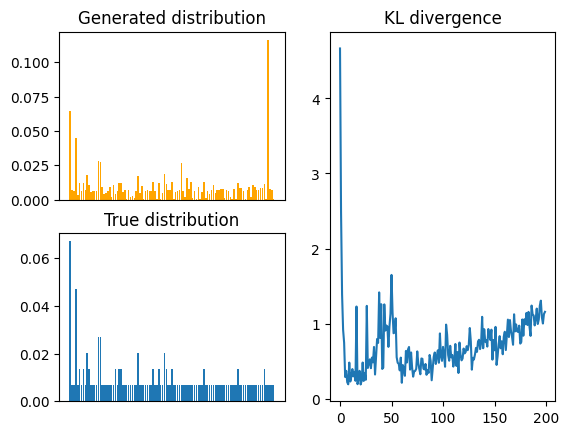

In [30]:
from disassembly.estimate_weights import estimate_weights

G, kls, generated, weights = estimate_weights(
    P=P,
    meta_enzyme=enzymes.meta_enzyme,
    exo_mult_factor=1,
    lr=2,
    n_iterations=200,
    N_T=1000,
    alpha=0.05,
)

fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 20), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 20

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

In [31]:
real_vs_estimated_weights = []
for node in sequence_graph.nodes():
    sum_out_edges = sum(
        [data["weight"] for _, _, data in sequence_graph.out_edges(node, data=True)]
    )
    for source, target, data in sequence_graph.out_edges(node, data=True):
        real_weight = data["weight"] / sum_out_edges
        estimated_weight = G[source][target]["weight"]
        real_vs_estimated_weights.append((real_weight, estimated_weight))
    for source, target, data in G.out_edges(node, data=True):
        if ~sequence_graph.has_edge(source, target):
            estimated_weight = data["weight"]
            real_vs_estimated_weights.append((-.1, estimated_weight))
print(sum([r for r,_ in real_vs_estimated_weights]))
print(sum([e for _,e in real_vs_estimated_weights]))

4.30000000000025
199.89859054111716


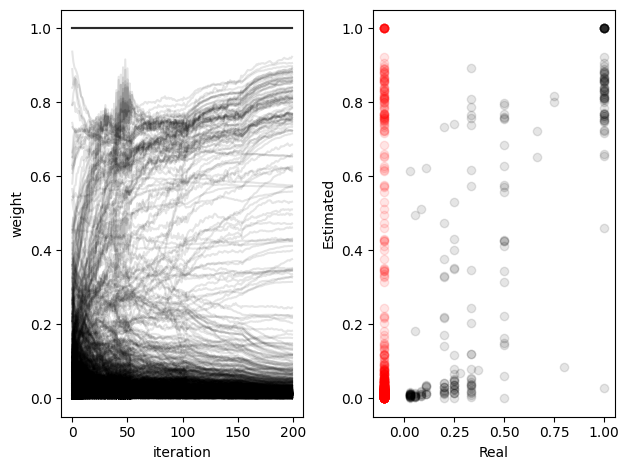

In [32]:
fig, axs = plt.subplots(1, 2)
axs[0].set_ylabel("weight")
axs[0].plot(weights.T, alpha=0.1, color="black")
for r, e in real_vs_estimated_weights:
    if r == -.1:
        axs[1].scatter(r, e, color="red", alpha=.1)
    else:
        axs[1].scatter(r, e, color="black", alpha=.1)
axs[1].set_xlabel("Real")
axs[1].set_ylabel("Estimated")
axs[0].set_xlabel("iteration")
plt.tight_layout()
plt.show()

In [33]:
from disassembly.disassembly import get_disassembly_indexes
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes(sequence_graph)
get_disassembly(P, real_disassembly_indexes)

Removing low prob. (<0.01) edges. Before: 119 | after: 119
 108 / 109 | checking 1 paths
 Averaged DI: 2.37


1.6223964491202365

In [34]:
estimated_disassembly_indexes = get_disassembly_indexes(G, min_weight = 0.01)
get_disassembly(P, estimated_disassembly_indexes)

Removing low prob. (<0.01) edges. Before: 938 | after: 866
 25 / 109 | checking 2097151 paths

KeyboardInterrupt: 

Text(0, 0.5, 'Estimated')

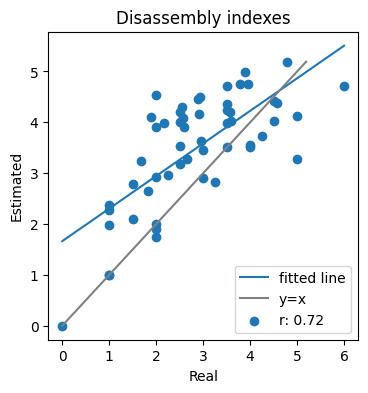

In [ ]:
from scipy.stats import linregress
import numpy as np


fig = plt.figure(figsize=(4, 4))
xs = []
ys = []
for key in P.keys():
    xs.append((real_disassembly_indexes[key]))
    ys.append((estimated_disassembly_indexes[key]))

regress = linregress(xs, ys)

plt.plot(
    np.linspace(0, max(xs)),
    regress.intercept + np.linspace(0, max(xs)) * regress.slope,
    label="fitted line",
)

plt.plot(np.linspace(0, max(ys)), np.linspace(0, max(ys)), color="gray", label="y=x")
plt.scatter(xs, ys, label=f"r: {regress.rvalue:.2f}")
plt.legend()
plt.title("Disassembly indexes")

plt.xlabel("Real")
plt.ylabel("Estimated")

Often overestimates the disassembly index. So far it actually seems as if we never underestimate disassembly.